In [85]:
import os
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Colab Notebooks/CSI 4900"
os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['testset-levelb.tsv',
 'labels-levelb.csv',
 'CSI4900_subtask2.ipynb',
 'CSI4900 TASK1.py',
 'labels-levela.csv',
 'olid-annotation.txt',
 'testset-levela.tsv',
 'olid-training-v1.0.tsv',
 'RESULT1.PNG',
 'OverFitting.PNG',
 '.ipynb_checkpoints',
 'output_SVM_learning.csv',
 'output_Bayes_learning.csv',
 'output_RandomForest_learning.csv',
 'CSI4900_TASK1.ipynb',
 'output_Bayes_learning_B.csv',
 'output_SVM_learning_B.csv',
 'output_RandomForest_learning_B.csv',
 'CSI4900 TASK2.ipynb']

In [86]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from collections import Counter
import re
import matplotlib.pyplot as plt

label_to_number_b = {'UNT':0,'TIN':1}

def clean_data(tweet):
    splitted_tweet = tweet.lower().split()
    clean_tweet = []
    previous_word = None
    user_count = 0
    for word in splitted_tweet:
        #if word not in spacy_stopwords:
        word = re.sub("[#@]","",word)
        word = re.sub("!"," !",word)
        word = re.sub("[?]"," ?",word)
        if(word == "@USER"):
          pass
        if(word == "user"):
          user_count += 1
        if(word == "user" and previous_word == "user"):
          pass
        else:
          clean_tweet.append(word)
        previous_word = word
    return " ".join(clean_tweet), user_count
    

#Deal with the dataset
def read(testfiletsv):
    plt.figure(figsize = (12,4))
    plt.subplot(132)
    a=pd.read_csv(testfiletsv, sep='\t',)
    cat_b = Counter(a["subtask_b"])
    x = cat_b.keys()
    x1 = []
    for i in x:
      if(isinstance(i,str)):
        x1.append(i)
    print(list(cat_b.values()))
    plt.bar(x1, [list(cat_b.values())[0],list(cat_b.values())[1]])
    plt.xticks(range(len(cat_b)), label_to_number_b)
    plt.title("Distribition of labels in subtask B");
    #since the distribution is not equal,we just choose 4000 from both sample
    dfUNT=a[a["subtask_b"] == "UNT"].sample(n=500, random_state=3)
    dfTIN = a[a["subtask_b"] == "TIN"].sample(n=500, random_state=2)
    #To prevent undersampling or Oversampling, we choose equal size of results
    dfPartial = dfUNT.append(dfTIN)
    return dfPartial


In [87]:
#First Method,Let us try Bays_learning method first
def learning(dfPartial):  
    train_reviews, test_reviews, train_tags, test_tags = train_test_split(dfPartial["tweet"],dfPartial["subtask_b"],test_size=0.1, random_state=3,             
                                                          stratify=dfPartial["subtask_b"])
    #we splite the training and testing datasets

    train_tags = train_tags.to_numpy()
    train_reviews = train_reviews.to_numpy()
    test_tags = test_tags.to_numpy()
    test_reviews = test_reviews.to_numpy()
    #convertion and normalization deal with data

    count_vect = CountVectorizer()
    train_counts = count_vect.fit_transform(train_reviews)
    negTrain=0;
    posTrain=0;
    posTest=0;
    negTest=0;
    trainSize = 900;
    testSize = 100;
    #Training process
    for i in range(trainSize):
        if (train_tags[i] == "UNT"):
            posTrain+=1
        if (train_tags[i] == "TIN"):
            negTrain+=1  
    for i in range(testSize):
        if (test_tags[i] == "UNT"):
            posTest+=1
        if (test_tags[i] == "TIN"):
            negTest+=1;
    return(train_counts, train_tags,count_vect)  

def Bayes_learning_result(train_counts, train_tags,count_vect,b):
    sentence=b['tweet']
    test_reviews_counts = count_vect.transform(sentence)
    clf = MultinomialNB().fit(train_counts, train_tags)  
    test_reviews_counts = count_vect.transform(sentence)
    # Predict the results
    prediction = clf.predict(test_reviews_counts)
    # Print the first ten predictions
    result=[]
    for idnum,docTest, categoryTest in zip(b['id'],b['tweet'], prediction):   
        #print('%r => %s\n' % (docTest, categoryTest))
        result.append([idnum,docTest, categoryTest])
    return(result)

[524, 3876, 8840]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


        id                                              tweet task2
0    15923  #WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...   TIN
1    60133  #NoPasaran: Unity demo to oppose the far-right...   TIN
2    83681           . . . What the fuck did he do this time?   UNT
3    65507  @USER Do you get the feeling he is kissing @US...   TIN
4    12588                        @USER Nigga ware da hits at   UNT
..     ...                                                ...   ...
235  22569  #Antifa are mentally unstable cowards, pretend...   TIN
236  48938  @USER @USER And Browning looked like dog shit ...   UNT
237  41438                All two of them taste like ass. URL   UNT
238  73439  #DespicableDems lie again about rifles. Dem Di...   TIN
239  67018  3 people just unfollowed me for talking about ...   UNT

[240 rows x 3 columns]


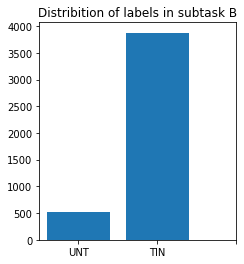

In [88]:
a=read('olid-training-v1.0.tsv')
for i in a["tweet"]:
  a["tweet"][i]=clean_data(i)
train_counts, train_tags,count_vect=learning(a)
b=pd.read_csv('testset-levelb.tsv', delimiter='\t',)
result=Bayes_learning_result(train_counts, train_tags,count_vect,b)
Bayes_learning_final=pd.DataFrame(result, columns=['id','tweet','task2'])
print(Bayes_learning_final)

In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
def  Randomforest_learning(train_counts, train_tags,count_vect,b):
    sentence=b['tweet']
    test_reviews_counts = count_vect.transform(sentence)
    classifier = RandomForestClassifier(max_depth=800, min_samples_split=5)
    params = {'n_estimators': [n for n in range(50,200,50)], 'criterion':['gini','entropy'], }
    classifier = GridSearchCV(classifier, params, cv=3, n_jobs=4)
    classifier.fit(train_counts, train_tags)
    # Predict the results
    prediction = classifier.predict(test_reviews_counts)
    # Print the first ten predictions
    result=[]
    for idnum,docTest, categoryTest in zip(b['id'],b['tweet'], prediction):   
        #print('%r => %s\n' % (docTest, categoryTest))
        result.append([idnum,docTest, categoryTest])
    return(result)

In [90]:
train_counts, train_tags,count_vect=learning(a)
b=pd.read_csv('testset-levelb.tsv', delimiter='\t',)
result=Randomforest_learning(train_counts, train_tags,count_vect,b)
Randomforest_learning_final=pd.DataFrame(result, columns=['id','tweet','task2'])
print(Randomforest_learning_final)

        id                                              tweet task2
0    15923  #WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...   TIN
1    60133  #NoPasaran: Unity demo to oppose the far-right...   TIN
2    83681           . . . What the fuck did he do this time?   UNT
3    65507  @USER Do you get the feeling he is kissing @US...   TIN
4    12588                        @USER Nigga ware da hits at   UNT
..     ...                                                ...   ...
235  22569  #Antifa are mentally unstable cowards, pretend...   TIN
236  48938  @USER @USER And Browning looked like dog shit ...   UNT
237  41438                All two of them taste like ass. URL   UNT
238  73439  #DespicableDems lie again about rifles. Dem Di...   TIN
239  67018  3 people just unfollowed me for talking about ...   UNT

[240 rows x 3 columns]


In [91]:
from sklearn.svm import SVC
def  SVM(train_counts, train_tags,count_vect,b):
    sentence=b['tweet']
    test_reviews_counts = count_vect.transform(sentence)
    classifier = SVC()
    classifier = GridSearchCV(classifier, {'C':[0.001, 0.01, 0.1, 1, 10]}, cv=3, n_jobs=4)
    classifier.fit(train_counts, train_tags)
    # Predict the results
    prediction = classifier.predict(test_reviews_counts)
    # Print the first ten predictions
    result=[]
    for idnum,docTest, categoryTest in zip(b['id'],b['tweet'], prediction):   
        #print('%r => %s\n' % (docTest, categoryTest))
        result.append([idnum,docTest, categoryTest])
    return(result)

In [92]:
train_counts, train_tags,count_vect=learning(a)
b=pd.read_csv('testset-levelb.tsv', delimiter='\t',)
result=SVM(train_counts, train_tags,count_vect,b)
SVM_final=pd.DataFrame(result, columns=['id','tweet','task2'])
print(SVM_final)

        id                                              tweet task2
0    15923  #WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...   UNT
1    60133  #NoPasaran: Unity demo to oppose the far-right...   TIN
2    83681           . . . What the fuck did he do this time?   UNT
3    65507  @USER Do you get the feeling he is kissing @US...   TIN
4    12588                        @USER Nigga ware da hits at   UNT
..     ...                                                ...   ...
235  22569  #Antifa are mentally unstable cowards, pretend...   TIN
236  48938  @USER @USER And Browning looked like dog shit ...   UNT
237  41438                All two of them taste like ass. URL   UNT
238  73439  #DespicableDems lie again about rifles. Dem Di...   UNT
239  67018  3 people just unfollowed me for talking about ...   UNT

[240 rows x 3 columns]


In [93]:
from sklearn import metrics
from sklearn.metrics import classification_report
def result_compare():
  b=pd.read_csv('labels-levelb.csv',names=["id","task2"])
  print("Bays_Learning")
  print(classification_report(b["task2"], Bayes_learning_final["task2"],target_names=["UNT","TIN"]))
  print("########################################################################################")
  Bayes_learning_final.to_csv("./output_Bayes_learning_B.csv")  
  print("RandomForest")
  print(classification_report(b["task2"], Randomforest_learning_final["task2"],target_names=["UNT","TIN"]))
  print("########################################################################################")
  Randomforest_learning_final.to_csv("./output_RandomForest_learning_B.csv") 
  print("SVM")
  print(classification_report(b["task2"], SVM_final["task2"],target_names=["UNT","TIN"]))
  SVM_final.to_csv("./output_SVM_learning_B.csv") 
result_compare()

Bays_Learning
              precision    recall  f1-score   support

         UNT       0.94      0.75      0.83       213
         TIN       0.23      0.59      0.33        27

    accuracy                           0.73       240
   macro avg       0.58      0.67      0.58       240
weighted avg       0.86      0.73      0.78       240

########################################################################################
RandomForest
              precision    recall  f1-score   support

         UNT       0.95      0.69      0.80       213
         TIN       0.23      0.74      0.35        27

    accuracy                           0.69       240
   macro avg       0.59      0.71      0.57       240
weighted avg       0.87      0.69      0.75       240

########################################################################################
SVM
              precision    recall  f1-score   support

         UNT       0.96      0.57      0.72       213
         TIN       0.19     